This is a 1 cell model with a PN cell and tone and shock inputs, in the configuration shown below
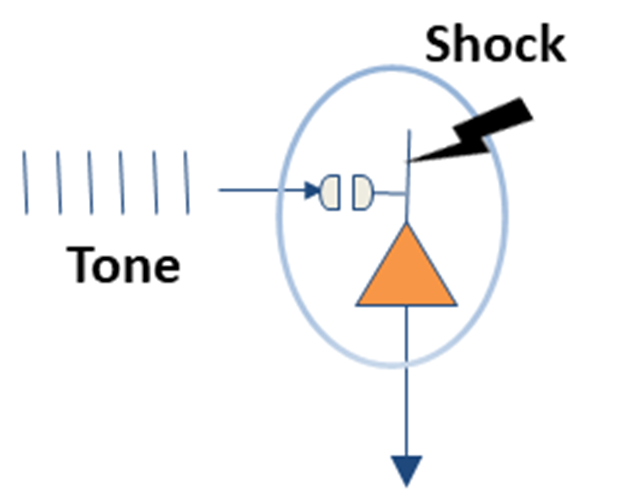

In [2]:
#@title Run cell to activate model
import os
import numpy as np
from os.path import normpath, sep, join

RunningInCOLAB = 'google.colab' in str(get_ipython())
print("Downloading model this will only take a min")
if RunningInCOLAB:
    !pip install ipywidgets==7.7.1 &> /dev/null
    !pip install neuron &> /dev/null
    root = 'Fear-Lesson-Plans'
    folder = 'D1'
    pathlist = normpath(os.getcwd()).split(sep)
    if pathlist[-1] != folder:
      rootidx = pathlist.index(root) if root in pathlist else -1
      if rootidx>0:
        os.chdir(join(sep,*pathlist[:rootidx]))
      !git clone https://github.com/GregGlickert/Fear-Lesson-Plans.git &> /dev/null 
      os.chdir(join(root,folder))

os.system('nrnivmodl modfiles') # compile modfiles. Return 0 for success, 1 for failure.

import matplotlib.pyplot as plt
from matplotlib import gridspec
from neuron import h
from neuron.units import ms, mV
import ipywidgets as widgets
from ipywidgets import interactive_output,HBox,VBox,Label,Layout
from IPython.display import display
%matplotlib inline
h.load_file('stdrun.hoc')

h.dt = 0.1 # time step (resolution) of the simulation in ms
h.tstop = 1700 # how long to run the simulation in ms
h.v_init= -65 # initial membrane potential in mV
h.load_file('PN_cells.hoc') # reads in template
cell = h.PN_C() #cell from template file
    

tone2pyr0 = h.pyr2pyr((cell.soma[0](0.5))) # makes a syn connected to soma
shock2pyr0 = h.pyr2pyr((cell.soma[0](0.5)))

def generate_spike_times(firing_rate,start_time, end_time):
    if firing_rate == 0:# in case shock is set to 0 fix divide by zero error
        firing_rate = 1
        start_time = 4000
        end_time = 5000
    interval = 1000.0 / firing_rate  # Interval between spikes in ms (1000 ms = 1 second)
    spike_times = []
    time = start_time
    while time <= end_time:
        spike_times.append(time)
        time += interval
    return spike_times


t = h.Vector()      # Vectors are used to record data in the simulation
Soma_v = h.Vector()

t.record(h._ref_t)                # derefences and records data
Soma_v.record(cell.soma[0](0.5)._ref_v)


def plot_variables(tone_freq,shock_start,shock_spike_times): # plots stuff
    
    fig = plt.figure(figsize=(15, 5),tight_layout=True) 
    gs = gridspec.GridSpec(2, 1, width_ratios=[1],height_ratios=[1,1]) 

    ax0 = plt.subplot(gs[1,:])
    ax1 = plt.subplot(gs[0,:])

    ax0.plot(t, Soma_v)
    ax0.legend(['Soma Vm'])
    ax0.set_ylabel('Voltage (mV)')
    ax0.set_xlabel('Time (ms)')
    ax0.set_ylim(-80,50)

    ax1.set_ylabel('Inputs')
    ax1.set_xlabel("Time (ms)")

    if tone_freq == 0:  # in case tone is set to 0 fix divide by zero error
        tone = np.arange(3000,4000,1)
    else:
        tone = np.arange(100,1750,1000/tone_freq)
    tone_index = []
    for i in range(len(tone)):
        tone_index.append(1)
    shock_index = []
    for i in range(len(shock_spike_times)):
        shock_index.append(2)
    
    ax1.scatter(tone,tone_index,label='Tone')
    ax1.scatter(shock_spike_times,shock_index,label='Shock')
    if tone_freq == 0:
        major_ticks = np.arange(3000,4000,1)
    else:
        major_ticks = np.arange(100, 1750, 1000/tone_freq)
    y_ticks = np.arange(1,3,1)
    ax1.set_xticks(major_ticks)
    ax1.set_yticks(y_ticks)
    ax1.legend()
    n = 4  # Keeps every 4th tick label
    [l.set_visible(False) for (i,l) in enumerate(ax1.xaxis.get_ticklabels()) if i % n != 0]
    ax1.grid()
    ax1.set_xlim(0,1800)
    ax1.set_ylim(0.8,2.2)
    
    plt.show()

def activemodel(initW_tone, initW_shock,tone,shock,shock_start,thres1=0.11, thres2=0.16):
    weight_tone = initW_tone
    if (weight_tone == 0):
        weight_tone = 0.0000000001
        
    weight_shock = initW_shock
    if (weight_shock == 0):
        weight_shock = 0.00000000001
        
    tone_freq = tone
    shock_freq = shock
    
    tone2pyr0.initW = weight_tone
    tone2pyr0.threshold1 = thres1
    tone2pyr0.threshold2 = thres2
    #soma[i].diam = 30
    
    nstim_tone = h.NetStim(0.9) # makes spike trains
    if (tone_freq != 0):
        nstim_tone.interval=(1000/tone_freq) # ms (mean) time between spikes
        nstim_tone.start = 100               # ms (most likely) start time of first spike
    else:
        nstim_tone.interval=0
        nstim_tone.start = 10000            # way to make the tone freq 0 during stim time
    nstim_tone.number = 100                 # (average) number of spikes
    nstim_tone.noise = 0                    # range 0 to 1. Fractional randomness.
    nc_tone = h.NetCon(nstim_tone,tone2pyr0,0,0,1)    # connects tone to soma via tone2pyr syn
    
    shock2pyr0.initW = weight_shock
    firing_rate = shock_freq  # Firing rate in Hz
    start_time = shock_start  # Start time in ms
    end_time = shock_start+999  # End time in ms

    
    shock_spike_times = generate_spike_times(firing_rate,start_time,end_time)
    netcons = [h.NetCon(None, shock2pyr0) for _ in shock_spike_times]
#    Create a NEURON event to deliver the spikes
    h.cvode.active(1)  # Activate the CVODE solver
    
    h.finitialize(h.v_init * mV)  # runs sims

    for netcon, time in zip(netcons, shock_spike_times):
        netcon.event(time)

    h.continuerun(h.tstop * ms) 
    plt.close('all')
    plot_variables(tone_freq,shock_start,shock_spike_times)

initW_tone = 1.1
initW_shock = 2
thres1 = 0.11
thres2 = 0.16
diam = 30
tone_freq = 10
shock_freq = 10
shock_start = 300

w_reset = widgets.Button(description='Reset',icon='history',button_style='primary')
w_initW_tone = widgets.FloatSlider(value=1.1, min=0, max=20, step=0.1,layout=Layout(width='20%', height='15px'))
w_initW_shock = widgets.FloatSlider(value=2, min=0, max=20, step=0.1,layout=w_initW_tone.layout)
w_shock_start = widgets.FloatSlider(value=300,min=0,max=1000,step=1,layout=w_initW_tone.layout)
w_tone_f = widgets.IntSlider(value=10, min=0, max=100, step=1,layout=w_initW_tone.layout)
w_shock_f = widgets.IntSlider(value=10, min=0, max=100, step=1,layout=w_initW_tone.layout)
w_thres1 = widgets.FloatSlider(value=0.11, min=0.01, max=1, step=0.05,layout=w_initW_tone.layout)
w_thres2 = widgets.FloatSlider(value=0.16, min=0.01, max=1, step=0.05,layout=w_initW_tone.layout)

def reset_default(*args):
    w_initW_tone.value = initW_tone
    w_initW_shock.value = initW_shock
    w_thres1.value = thres1
    w_thres2.value = thres2
    w_tone_f.value = tone_freq
    w_shock_f.value = shock_freq
    w_shock_start.value = shock_start
    
w_reset.on_click(reset_default)

labels = ['Tone Freq','Shock Freq','Shock Start Time','Tone Weight','Shock Weight','Threshold1','Threshold2']
Labels = [Label(L) for L in labels]

ui = VBox([ HBox([w_reset]),
           HBox([Labels[0],w_tone_f,Labels[1], w_shock_f,Labels[2],w_shock_start]),
           HBox([Labels[3],w_initW_tone,Labels[4],w_initW_shock])])
out = interactive_output(activemodel, {'initW_tone':w_initW_tone,'initW_shock':w_initW_shock,
                                       'tone':w_tone_f,'shock':w_shock_f,'shock_start':w_shock_start})

display(ui,out)




/usr/bin/xcrun
/Users/gregglickert/Documents/GitHub/Fear-Lesson-Plans/D1
Mod files: "modfiles/modfiles/AMPA_NMDA_STP.mod" "modfiles/modfiles/Gfluct_new_exc.mod" "modfiles/modfiles/Gfluct_new_inh.mod" "modfiles/modfiles/cadyn.mod" "modfiles/modfiles/capool.mod" "modfiles/modfiles/currentclamp.mod" "modfiles/modfiles/h.mod" "modfiles/modfiles/im.mod" "modfiles/modfiles/kadist.mod" "modfiles/modfiles/kaprox.mod" "modfiles/modfiles/kdrca1.mod" "modfiles/modfiles/leak.mod" "modfiles/modfiles/na3.mod" "modfiles/modfiles/nap.mod" "modfiles/modfiles/pyr2pyr.mod" "modfiles/modfiles/sahp.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib
Successfully created x86_64/special


Output()